In [ ]:
import torch
import numpy as np
import torch.nn as nn
from torch.utils.data import random_split
import torch.nn.functional as F
from torchvision import transforms
from torchvision.transforms import v2
import torchvision.models as models
import torchvision.datasets as datasets
import torchvision
from torch.utils.data import DataLoader, Dataset, Subset
from torch import flatten, optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

#from torchvision.models import AlexNet, AlexNet_Weights.IMAGENET1K_V1

from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print("device is", device)

device is cuda:0


In [ ]:
BATCH_SIZE = 8


# Define the transformations to apply to the dataset
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),    # Convert PIL image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])    # Normalize the image



# Load the CIFAR-10 training dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

# Create a DataLoader to load the data in batches
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

# Load the CIFAR-10 test dataset
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

# Create a DataLoader for the test data
testloader = torch.utils.data.DataLoader(testset, BATCH_SIZE,
                                         shuffle=False, num_workers=2)

# Split the training set into training and validation sets
train_size = int(0.8 * len(trainset))
val_size = len(trainset) - train_size
trainset, valset = torch.utils.data.random_split(trainset, [train_size, val_size])


# Define the classes in CIFAR-10
classes = ('airplane', 'automobile', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

val_loader = torch.utils.data.DataLoader(valset, BATCH_SIZE, shuffle=False, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


# Help Functions

In [ ]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs):
    best_val_loss = float('inf')
    best_model = model

    for epoch in range(num_epochs):
        print(epoch, "ANTON")
        model.train()
        train_loss = 0.0
        for batch_nr, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss = loss.to(device)
            if (batch_nr%300 == 0):
                print("batch_nr:",batch_nr," loss:",loss.item())
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
        
        train_loss /= len(train_loader.dataset)
        
        writer.add_scalar("loss/train", train_loss, epoch)
    
    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
        
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
    
    val_loss /= len(val_loader.dataset)
    
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
    
    # Save the best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model
    
    writer.flush()
    return best_model

def test_model(model, test_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        test_loss = 0.0
        correct = 0
        total = 0
        all_predictions = []
        all_targets = []

        for inputs, labels in test_loader:
            inputs, labels = inputs.cuda(), labels.cuda()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())

        test_loss /= len(test_loader.dataset)
        accuracy = 100 * correct / total
        
        # Calculate confusion matrix
        conf_matrix = confusion_matrix(all_targets, all_predictions)

    return test_loss, accuracy, conf_matrix

cuda:0


Using cache found in C:\Users\ludvi/.cache\torch\hub\pytorch_vision_v0.10.0


0 ANTON
batch_nr: 0  loss: 2.6175713539123535
batch_nr: 300  loss: 1.3244061470031738
batch_nr: 600  loss: 0.5305525660514832
batch_nr: 900  loss: 1.3550341129302979
batch_nr: 1200  loss: 0.7885894179344177
batch_nr: 1500  loss: 0.9159942269325256
batch_nr: 1800  loss: 1.0963983535766602
batch_nr: 2100  loss: 0.6960331201553345
batch_nr: 2400  loss: 0.2764701545238495
batch_nr: 2700  loss: 0.43083280324935913
batch_nr: 3000  loss: 0.508567214012146
batch_nr: 3300  loss: 0.6725679636001587
batch_nr: 3600  loss: 0.2079649120569229
batch_nr: 3900  loss: 1.0249946117401123
batch_nr: 4200  loss: 0.47212663292884827
batch_nr: 4500  loss: 0.9139701128005981
batch_nr: 4800  loss: 0.3618440330028534
batch_nr: 5100  loss: 0.4810100793838501
batch_nr: 5400  loss: 0.6385907530784607
batch_nr: 5700  loss: 0.2894635498523712
batch_nr: 6000  loss: 0.17671708762645721
1 ANTON
batch_nr: 0  loss: 0.22808702290058136
batch_nr: 300  loss: 0.5628567934036255
batch_nr: 600  loss: 0.26697754859924316
batch_n

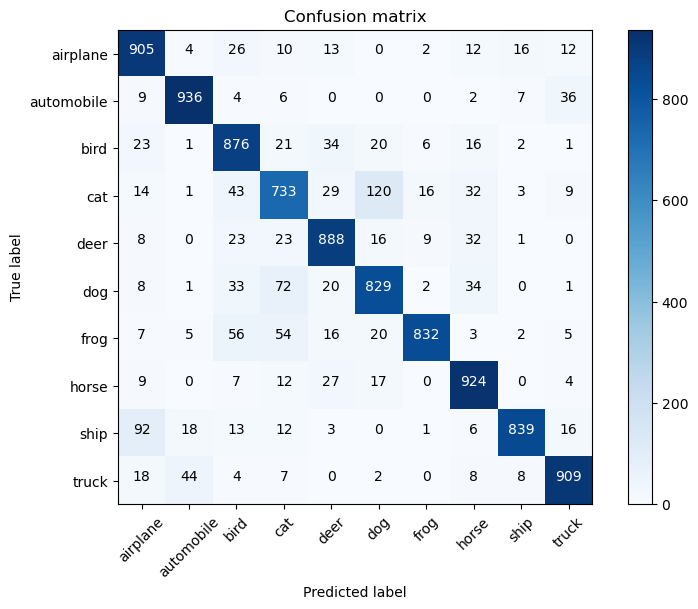

In [23]:
LEARNING_RATE = 0.0001
EPOCHS = 10

print(device)
#model = CNN(num_classes=10).to(device)


model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)

#model.eval()
#model_ft = models.resnet18(pretrained=True) So this is example of resnet18
#model_ft.fc = nn.Linear(512, 2)
#Alexnet output is 1000
#Ours is 10
#model.fc=nn.Linear(1000,10) ??

criterion = torch.nn.CrossEntropyLoss().to(device)
# optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
# alexnet = models.alexnet(pretrained=True)
# num_featu#res = model.classifier[6].in_features
#
model.classifier.append(nn.Linear(1000, 10))

model = model.to(device)


# Train the model
trained_model = train_model(model, criterion, optimizer, trainloader, val_loader, EPOCHS)
# Test the model
test_loss, test_accuracy, conf_matrix = test_model(trained_model, testloader, criterion)

print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')
plt.figure(figsize=(8, 6))
plot_confusion_matrix(conf_matrix, classes=classes, normalize=False)
plt.show()

writer.close()